The following imports and functions are the same as the ones in *Laboratory 3*. We repeat them here for convenience.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [2]:
def get_fashion_mnist_labels(labels) -> list[str]:
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    
    return [text_labels[int(i)] for i in labels]

In [3]:
def show_images(imgs: list[torch.Tensor], num_rows: int, num_cols: int, titles=None, scale: int=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
            
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        if titles:
            ax.set_title(titles[i])
            
    return axes

In [4]:
def load_data_fashion_mnist(batch_size: int, resize=None) -> tuple[DataLoader, DataLoader, DataLoader]:
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    # get training data
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    # get test data
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    
    return (DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [5]:
def evaluate_accuracy(net: nn.Module, data_iter) -> tuple[float, float]:
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss: float = 0
    total_hits: int = 0
    total_samples: float = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            
            l = loss(y_hat, y)
            
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
            
    return total_loss / len(data_iter), total_hits / total_samples  * 100

In [36]:
from typing import Callable
from torch import Tensor
from torch.optim.optimizer import Optimizer

def train_epoch(net: nn.Module, train_iter: DataLoader, loss: Callable[..., Tensor], optimizer: Optimizer) -> tuple[float, float]:
    # Set the model to training mode
    net.train()
    
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
        
    # Return training loss and training accuracy
    return total_loss / len(train_iter), total_hits / total_samples  * 100

In [62]:
from termcolor import colored

def diff_color(diff: float, is_pos: bool) -> str:
    if (diff > 0.0 and is_pos) or (diff < 0.0 and not is_pos):
        return "green"
    return "red"

def print_epoch_summary(epoch: int, train_loss: float, train_acc: float, val_loss: float, val_acc: float, last_values: tuple[float, float, float, float]):
    if epoch == 0:
        print(f'{epoch + 1:5} | {train_loss:12.2f} | {train_acc:13.2f}% | {val_loss:15.2f} | {val_acc:18.2f}%')
    else:
        train_loss_diff = train_loss - last_values[0]
        train_acc_diff = train_acc - last_values[1]
        val_loss_diff = val_loss - last_values[2]
        val_acc_diff = val_acc - last_values[3]
        print(f'{epoch + 1:5} | ({colored(f"{train_loss_diff:+3.2f}", diff_color(train_loss_diff, False))}) {train_loss:4.2f} ', end='')
        print(f'| ({colored(f"{train_acc_diff:+3.2f}", diff_color(train_acc_diff, True))}) {train_acc:5.2f}% ', end='')
        print(f'|    ({colored(f"{val_loss_diff:+3.2f}", diff_color(val_loss_diff, False))}) {val_loss:3.2f} ', end='')
        print(f'|      ({colored(f"{val_acc_diff:+3.2f}", diff_color(val_acc_diff, True))}) {val_acc:5.2f}%')

In [60]:
def train(net: nn.Module, train_iter: DataLoader, val_iter: DataLoader, loss: Callable[..., Tensor], num_epochs: int, optimizer: Optimizer):
    """Train a model."""
    train_loss_all: list[float] = []
    train_acc_all: list[float] = []
    val_loss_all: list[float] = []
    val_acc_all: list[float] = []
    
    last_values = (0.0, 0.0, 0.0, 0.0)
    print(f'Epoch |   Train Loss | Train Accuracy | Validation Loss | Validation Accuracy')
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        
        print_epoch_summary(epoch, train_loss, train_acc, val_loss, val_acc, last_values)
        last_values = (train_loss, train_acc, val_loss, val_acc)

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

## Plotting

In [68]:
import plotly.express as px
import plotly.graph_objects as go

In [77]:
def plot_loss(train_loss_all: list[float], val_loss_all: list[float]):
    epochs = list(range(1, len(train_loss_all) + 1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train_loss_all, name='Training loss'))
    fig.add_trace(go.Scatter(x=epochs, y=val_loss_all, name='Validation loss'))
    fig.update_layout(
        title='Training and validation loss',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        font = {
            'size': 18,
            'color': 'white'
        },
        xaxis = {
            'title': 'Epochs',
        }, 
        yaxis = {
            'title': 'Loss',
        })
    fig.show()

In [78]:
def plot_accuracy(train_acc_all: list[float], val_acc_all: list[float]):
    epochs = list(range(1, len(train_acc_all) + 1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train_acc_all, name='Training accuracy'))
    fig.add_trace(go.Scatter(x=epochs, y=val_acc_all, name='Validation accuracy'))
    fig.update_layout(
        title='Training and validation accuracy',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        font = {
            'size': 18,
            'color': 'white'
        },
        xaxis = {
            'title': 'Epochs',
        }, 
        yaxis = {
            'title': 'Accuracy',
        }
    )
    fig.show()

In [10]:
def predict(net, test_iter, n=18):
    """Predict labels."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 2, int(n/2), titles=titles[0:n])

# Multilayer perceptrons

As compared with our implementation
of softmax regression,
the only difference is that we add
*two* fully-connected layers
(previously, we added *one*).
The first is our *hidden layer*,
which contains $256$ hidden units,
and applies the ReLU activation function.
The second is our *output layer*.

In [41]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
)

def init_weights(m: nn.Module | nn.Linear):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

The training loop is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from other considerations.

In [54]:
batch_size, lr, num_epochs = 256, 0.1, 10

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

In [63]:
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch |   Train Loss | Train Accuracy | Validation Loss | Validation Accuracy
    1 |         0.31 |         88.75% |            0.41 |              85.88%
    2 | (-0.00) 0.31 | (+0.13) 88.88% |    (-0.07) 0.34 |      (+1.77) 87.65%
    3 | (-0.01) 0.30 | (+0.31) 89.19% |    (+0.02) 0.36 |      (-0.79) 86.86%
    4 | (-0.00) 0.30 | (-0.04) 89.14% |    (-0.02) 0.34 |      (+0.66) 87.52%
    5 | (-0.00) 0.30 | (+0.06) 89.20% |    (+0.01) 0.35 |      (-0.19) 87.33%
    6 | (-0.01) 0.29 | (+0.28) 89.48% |    (-0.01) 0.35 |      (+0.13) 87.46%
    7 | (-0.00) 0.29 | (+0.06) 89.54% |    (-0.00) 0.34 |      (-0.07) 87.39%
    8 | (-0.00) 0.29 | (+0.04) 89.58% |    (+0.02) 0.37 |      (-0.98) 86.41%
    9 | (-0.00) 0.29 | (+0.19) 89.77% |    (-0.04) 0.33 |      (+1.76) 88.17%
   10 | (-0.00) 0.28 | (+0.10) 89.87% |    (+0.01) 0.34 |      (-0.39) 87.78%


In [79]:
plot_loss(train_loss_all, val_loss_all)

In [80]:
plot_accuracy(train_acc_all, val_acc_all)

In [81]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.36, Test accuracy 86.92


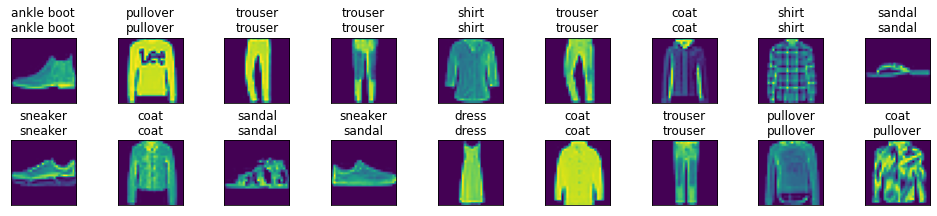

In [82]:
predict(net, test_iter)

# Weight decay

Because weight decay is ubiquitous
in neural network optimization,
the deep learning framework makes it especially convenient,
integrating weight decay into the optimization algorithm itself,
for easy use in combination with any loss function.
Moreover, this integration serves a computational benefit,
allowing implementation tricks to add weight decay to the algorithm,
without any additional computational overhead.
Since the weight decay portion of the update
depends only on the current value of each parameter,
the optimizer must touch each parameter once anyway.

In the following code, we specify
the weight decay hyperparameter directly
through `weight_decay`, when instantiating our optimizer.
By default, PyTorch decays both
weights and biases simultaneously.


In [83]:
wd = 0.001
optimizer = torch.optim.SGD(net.parameters(), weight_decay=wd, lr=lr)

Since we do not change the network architecture at all, `net` will be the same as before. However, in order to train the network from scratch, we call the `net.apply(init_weights)` method to reinitialize the weights randomly.

Note that the training error increases,
but the test error decreases.
This is precisely the effect
we expect from regularization.

In [84]:
net.apply(init_weights)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch |   Train Loss | Train Accuracy | Validation Loss | Validation Accuracy
    1 |         1.06 |         64.87% |            0.90 |              69.18%
    2 | (-0.45) 0.61 | (+13.29) 78.16% |    (-0.33) 0.57 |      (+10.19) 79.37%
    3 | (-0.08) 0.53 | (+3.04) 81.20% |    (-0.06) 0.52 |      (+2.80) 82.17%
    4 | (-0.03) 0.50 | (+1.18) 82.38% |    (+0.09) 0.61 |      (-4.12) 78.05%
    5 | (-0.03) 0.47 | (+1.21) 83.59% |    (-0.11) 0.51 |      (+2.91) 80.96%
    6 | (-0.02) 0.45 | (+0.55) 84.13% |    (-0.06) 0.44 |      (+3.17) 84.13%
    7 | (-0.02) 0.44 | (+0.53) 84.66% |    (+0.01) 0.46 |      (-0.26) 83.87%
    8 | (-0.01) 0.43 | (+0.31) 84.97% |    (-0.04) 0.42 |      (+0.91) 84.78%
    9 | (-0.01) 0.42 | (+0.47) 85.44% |    (+0.04) 0.46 |      (-0.60) 84.18%
   10 | (-0.01) 0.41 | (+0.28) 85.72% |    (-0.05) 0.41 |      (+0.99) 85.17%


In [85]:
plot_loss(train_loss_all, val_loss_all)

In [86]:
plot_accuracy(train_acc_all, val_acc_all)

In [87]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}%')

Test loss 0.43, Test accuracy 84.39


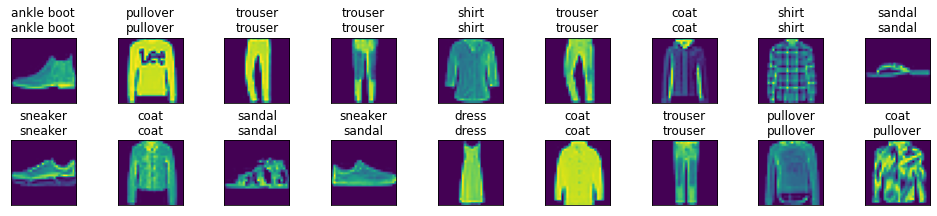

In [88]:
predict(net, test_iter)

# Dropout

With high-level APIs, all we need to do is add a `nn.Dropout` layer
after each fully-connected layer,
passing in the dropout probability
as the only argument to its constructor.
During training, the `nn.Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability. Here, we will drop $20\%$ of the outputs of the first hidden layer, and $30\%$ of the outputs of the second hidden layer. 
When not in training mode,
the `nn.Dropout` layer simply passes the data through, during testing.

In [ ]:
dropout1, dropout2 = 0.2, 0.3

net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10)
)

def init_weights(m: nn.Module | nn.Linear):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

Next, we train and test the model.

In [89]:
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch |   Train Loss | Train Accuracy | Validation Loss | Validation Accuracy
    1 |         0.40 |         86.11% |            0.45 |              84.35%
    2 | (-0.01) 0.39 | (+0.10) 86.21% |    (-0.03) 0.41 |      (+0.61) 84.96%
    3 | (-0.01) 0.38 | (+0.28) 86.49% |    (-0.03) 0.39 |      (+1.26) 86.22%
    4 | (-0.01) 0.37 | (+0.29) 86.78% |    (-0.01) 0.38 |      (+0.04) 86.26%
    5 | (-0.01) 0.36 | (+0.32) 87.10% |    (+0.01) 0.39 |      (-0.83) 85.43%
    6 | (-0.00) 0.36 | (+0.14) 87.24% |    (+0.01) 0.40 |      (-0.10) 85.33%
    7 | (-0.01) 0.35 | (+0.18) 87.42% |    (-0.02) 0.38 |      (+0.95) 86.28%
    8 | (-0.01) 0.35 | (+0.23) 87.64% |    (+0.03) 0.41 |      (-1.59) 84.69%
    9 | (-0.00) 0.34 | (+0.04) 87.68% |    (+0.02) 0.43 |      (-1.30) 83.39%
   10 | (-0.01) 0.34 | (+0.19) 87.87% |    (-0.05) 0.38 |      (+3.02) 86.41%


In [90]:
plot_loss(train_loss_all, val_loss_all)

In [91]:
plot_accuracy(train_acc_all, val_acc_all)

In [ ]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.43, Test accuracy 84.50


# Deep learning computation

To implement complex neural networks,
we introduce the concept of a neural network *block*.
A block could describe a single layer,
a component consisting of multiple layers,
or the entire model itself.
One benefit of working with the block abstraction
is that they can be combined into larger artifacts,
often recursively. By defining code to generate blocks
of arbitrary complexity on demand,
we can write surprisingly compact code
and still implement complex neural networks.

From a programing standpoint, a block is represented by a *class*.
Any subclass of it must define a forward propagation function
that transforms its input into output
and must store any necessary parameters.
Note that some blocks do not require any parameters at all.
Finally, a block must possess a backpropagation function,
for the purpose of calculating gradients.
Fortunately, due to the auto differentiation mechanism,
when defining our own block,
we only need to worry about parameters
and the forward propagation function.

To begin, we revisit the code
that we used to implement MLPs.
The following code generates a network
with one fully-connected hidden layer
with $256$ units and ReLU activation,
followed by a fully-connected output layer
with $10$ units (no activation function).

In [92]:
net = nn.Sequential(
    nn.Linear(20, 256), 
    nn.ReLU(), 
    nn.Linear(256, 10)
)

X = torch.rand(2, 20)
net(X)

tensor([[ 0.1971, -0.0048, -0.0994, -0.0759, -0.2336,  0.3708,  0.0392, -0.0417,
         -0.0420,  0.3189],
        [ 0.1910,  0.0726, -0.0528, -0.1596, -0.1825,  0.2290, -0.0762, -0.0334,
         -0.1225,  0.3000]], grad_fn=<AddmmBackward0>)

In this example, we constructed
our model by instantiating an `nn.Sequential`, with layers in the order
that they should be executed, passed as arguments.
In short, `nn.Sequential` defines a special kind of `nn.Module`,
the class that represents a block in PyTorch.
It maintains an ordered list of constituent `nn.Module`s.
Note that each of the two fully-connected layers is an instance of the `nn.Linear` class, which is itself a subclass of `nn.Module`.
The forward propagation (`forward()`) function is also remarkably simple:
it chains each block in the list together,
passing the output of each as the input to the next.
Note that, until now, we have been invoking our models
via the construction `net(X)` to obtain their outputs.
This is actually just shorthand for `net.__call__(X)`.

Perhaps the easiest way to develop intuition
about how a block works
is to implement one ourselves.
Before we implement our own custom block,
we briefly summarize the basic functionality
that each block must provide:

1. Ingest input data as arguments to its forward propagation function.
1. Generate an output by having the forward propagation function return a value. Note that the output may have a different shape from the input. For example, the first fully-connected layer in our model above ingests an input of dimension $20$, but returns an output of dimension $256$.
1. Calculate the gradient of its output with respect to its input, which can be accessed via its backpropagation function. Typically, this happens automatically.
1. Store and provide access to those parameters necessary
   to execute the forward propagation computation.
1. Initialize model parameters as needed.

In the following,
we code a block from scratch
corresponding to an MLP
with one hidden layer with $256$ hidden units,
and a $10$-dimensional output layer.
Note that the `MLP` class below inherits the class that represents a block.
We will heavily rely on the parent class's functions,
supplying only our own constructor (the `__init__` function in Python) and the forward propagation function.

In [93]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `nn.Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # Hidden layer
        self.out = nn.Linear(256, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output, based on the input `X`
    def forward(self, X):
        # Note here we use the nn.ReLU class for the ReLU activation function
        return self.out(nn.ReLU()(self.hidden(X)))

Let us first focus on the forward propagation function.
Note that it takes `X` as the input,
calculates the hidden representation
with the activation function applied,
and outputs its logits.
In this `MLP` implementation,
both layers are instance variables.
To see why this is reasonable, imagine
instantiating two MLPs, `net1` and `net2`,
and training them on different data.
Naturally, we would expect them
to represent two different learned models.

We instantiate the MLP's layers
in the constructor
and subsequently invoke these layers
on each call to the forward propagation function.
Note a few key details.
First, our customized `__init__` function
invokes the parent class's `__init__` function
via `super().__init__()`,
sparing us of restating code applicable to most blocks.
We then instantiate our two fully-connected layers,
assigning them to `self.hidden` and `self.out`.
Note that, unless we implement a new operator,
we need not worry about the backpropagation function
or parameter initialization.
The system will generate these functions automatically.
Let us try this out.

In [94]:
net = MLP()
net(X)

tensor([[ 0.2750,  0.1027, -0.3359, -0.3731,  0.0453, -0.1573,  0.1011, -0.0328,
         -0.1331, -0.2903],
        [ 0.1772,  0.1124, -0.3073, -0.4613, -0.0666, -0.2219,  0.2725,  0.0631,
         -0.2417, -0.3648]], grad_fn=<AddmmBackward0>)

A key virtue of the block abstraction is its versatility.
We can subclass a block to create layers
(such as the fully-connected layer class),
entire models (such as the `MLP` class above),
or various components of intermediate complexity.
We exploit this versatility
throughout the following laboratories,
such as when addressing
convolutional neural networks.

We can now take a closer look
at how the `nn.Sequential` class works.
Recall that `nn.Sequential` was designed
to chain other blocks together one after the other.
To build our own simplified `MySequential`,
we just need to define two key functions:
1. A function to append blocks one by one to a list.
2. A forward propagation function to pass an input through the chain of blocks, in the same order as they were appended.

The following `MySequential` class delivers the same
functionality as the default `nn.Sequential` class.

In [95]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Here, `module` is an instance of a `nn.Module` subclass. We save it
            # in the member variable `_modules` of the `nn.Module` class, and its
            # type is OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X

In the `__init__` method, we add every module
to the ordered dictionary `_modules` one by one.
We might wonder why every `nn.Module`
possesses a `_modules` attribute
and why we used it, rather than just
defining a Python list ourselves.
In short, the main advantage of `_modules`
is that, during our module's parameter initialization,
the system knows to look inside the `_modules`
dictionary to find sub-modules whose
parameters also need to be initialized.

When our `MySequential`'s forward propagation function is invoked,
each added block is executed
in the order in which they were added.
We can now reimplement an MLP
using our `MySequential` class.

In [96]:
net = MySequential(
    nn.Linear(20, 256), 
    nn.ReLU(), 
    nn.Linear(256, 10)
)
net(X)

tensor([[-0.1827,  0.0347,  0.0911, -0.2604, -0.0842,  0.2763,  0.2634, -0.1825,
         -0.2143,  0.1298],
        [-0.1332,  0.0094,  0.1380, -0.2727, -0.0086,  0.1804,  0.1348, -0.2191,
         -0.1307,  0.1837]], grad_fn=<AddmmBackward0>)

Note that this use of `MySequential`
is identical to the code we previously wrote
for the `nn.Sequential` class.

The `nn.Sequential` class makes model construction easy,
allowing us to assemble new architectures
without having to define our own class.
However, not all architectures are simple chains of layers.
When greater flexibility is required,
we will want to define our own blocks.
For example, we might want to execute
Python's control flow within the forward propagation function.
Moreover, we might want to perform
arbitrary mathematical operations,
not simply relying on predefined neural network layers. Thus, we can integrate
arbitrary code into the flow of our
neural network computations.

Once we have chosen an architecture
and set our hyperparameters,
we proceed to the training loop,
where our goal is to find parameter values
that minimize our loss function.
After training, we will need these parameters
in order to make future predictions.
Additionally, we will sometimes wish
to extract the parameters
either to reuse them in some other context,
to save our model to disk so that
it may be executed in other software,
or for examination in the hope of
gaining scientific understanding.

Most of the time, we will be able
to ignore the details
of how parameters are declared
and manipulated, relying on deep learning frameworks
to do the heavy lifting.
However, when we move away from
stacked architectures with standard layers,
we will sometimes need to get into the details
of declaring and manipulating parameters.

We start by focusing on an MLP with one hidden layer.

In [97]:
net = nn.Sequential(
    nn.Linear(4, 8), 
    nn.ReLU(), 
    nn.Linear(8, 1)
)
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.0325],
        [-0.0890]], grad_fn=<AddmmBackward0>)

Let us start with how to access parameters
from the models that we already know.
When a model is defined via the `nn.Sequential` class,
we can first access any layer by indexing
into the model as though it were a list.
Each layer's parameters are conveniently
located in its attribute.
We can inspect the parameters of the second fully-connected layer as follows.

In [98]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[ 0.1617,  0.2700,  0.3075, -0.3363,  0.2465, -0.3005, -0.0646,  0.3137]])), ('bias', tensor([-0.0840]))])


The output tells us a few important things.
First, this fully-connected layer
contains two parameters,
corresponding to that layer's
weights and biases, respectively.
Both are stored as single precision floats (`float32`).
Note that the names of the parameters
allow us to uniquely identify
each layer's parameters,
even in a network containing hundreds of layers.

Note that each parameter is represented
as an instance of the parameter class.
To do anything useful with the parameters,
we first need to access the underlying numerical values.
There are several ways to do this.
Some are simpler, while others are more general.
The following code extracts the bias
from the second neural network layer, which returns a `Parameter` class instance, and 
further accesses that parameter's value.

In [99]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.0840], requires_grad=True)
tensor([-0.0840])


Parameters are complex objects,
containing values, gradients,
and additional information.
That's why we need to request the value explicitly.

In addition to the value, each parameter also allows us to access the gradient. Because we have not invoked backpropagation for this network yet, it is in its initial state.

In [ ]:
net[2].weight.grad == None

True

When we need to perform operations on all parameters,
accessing them one-by-one can grow tedious.
The situation can become especially tedious
when we work with more complex blocks (e.g., nested blocks),
since we would need to traverse the entire tree to extract
each sub-block's parameters. Below we demonstrate accessing the parameters of the first fully-connected layer vs. accessing all layers.

In [ ]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


This provides us with another way of accessing the parameters of the network as follows.

In [ ]:
net.state_dict()['2.bias'].data

tensor([-0.0215])

Let us now see how the parameter naming conventions work
if we nest multiple blocks inside each other.
For that, we first define a function that produces blocks
(a block factory, so to speak) and then
combine these inside yet larger blocks.

In [ ]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[0.4790],
        [0.4790]], grad_fn=<AddmmBackward0>)

Now that we have designed the network,
let us see how it is organized.

In [ ]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


Since the layers are hierarchically nested,
we can also access them as though
indexing through nested lists.
For instance, we can access the first major block,
within it the second sub-block,
and within that the bias of the first layer, as follows:

In [ ]:
rgnet[0][1][0].bias.data

tensor([ 0.1509, -0.0985,  0.4153, -0.2662, -0.4296, -0.3925, -0.3151, -0.2948])

Now that we know how to access the parameters,
let us look at how to initialize them properly.
We discussed the need for proper initialization in the course.
The deep learning framework provides default random initializations to its layers.
However, we often want to initialize our weights
according to various other protocols. The framework provides most commonly
used protocols, and also allows us to create a custom initializer.

By default, PyTorch initializes weight and bias matrices
uniformly, by drawing from a range that is computed according to the input and output dimension.
PyTorch's `nn.init` module provides a variety
of preset initialization methods.

Let us begin by calling on built-in initializers.
The code below initializes all weight parameters
as Gaussian random variables
with standard deviation $0.01$, while bias parameters are cleared to zero.

In [ ]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0229,  0.0040,  0.0015, -0.0036]), tensor(0.))

We can also initialize all the parameters
to a given constant value (say, $1$).

In [ ]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

We can also apply different initializers for certain blocks.
For example, below we initialize the first layer
with the Xavier initializer
and initialize the second layer
to a constant value of $42$.

In [ ]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.4192, -0.4082, -0.4657, -0.2263])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


Note that we always have the option
of setting parameters directly.

In [ ]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  0.5918,  0.5343,  0.7737])

So far, we discussed how to process data and how
to build, train, and test deep learning models.
However, at some point, we will hopefully be happy enough
with the learned models that we will want
to save the results for later use in various contexts
(perhaps even to make predictions in deployment).
Additionally, when running a long training process,
the best practice is to periodically save intermediate results (checkpointing)
to ensure that we do not lose several days worth of computation
if we power goes down.
Thus, it is time to learn how to load and store
both individual weight vectors and entire models.

For individual tensors, we can directly
invoke the `load()` and `save()` functions
to read and write them, respectively.
Both functions require that we supply a name,
and `save()` requires as input the variable to be saved.

In [ ]:
x = torch.arange(4)
torch.save(x, 'x-file')

We can now read the data from the stored file back into memory.

In [ ]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

We can store a list of tensors and read them back into memory.

In [ ]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

We can even write and read a dictionary that maps
from strings to tensors.
This is convenient when we want
to read or write all the weights in a model.

In [ ]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

Saving individual weight vectors (or other tensors) is useful,
but it gets very tedious if we want to save
(and later load) an entire model.
After all, we might have hundreds of
parameter groups sprinkled throughout.
For this reason the deep learning framework provides built-in functionalities
to load and save entire networks.
An important detail to note is that this
saves model *parameters*, and not the entire model.
For example, if we have a $3$-layer MLP,
we need to specify the architecture separately.
The reason for this is that the models themselves can contain arbitrary code,
hence they cannot be serialized as naturally.
Thus, in order to reinstate a model, we need
to generate the architecture in code
and then load the parameters from disk.
Let us start with our familiar MLP.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(nn.ReLU()(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

Next, we store the parameters of the model as a file with the name "mlp.params".

In [ ]:
torch.save(net.state_dict(), 'mlp.params')

To recover the model, we instantiate a clone
of the original MLP model.
Instead of randomly initializing the model parameters,
we read the parameters stored in the file directly.

In [ ]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

Since both instances have the same model parameters,
the computational result of the same input `X` should be the same.
Let us verify this.

In [ ]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

In the past two decades, GPU performance has increased
by a factor of $1000$ every decade since 2000.
This offers great opportunities, but it also suggests
a significant need to provide such performance.

Next, we discuss how to harness
this computational performance.
Specifically, we will discuss how
to use a single NVIDIA GPU for calculations.
The `nvidia-smi` command can be used
to view the graphics card information.

In [ ]:
!nvidia-smi

Sat Apr 16 09:00:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In PyTorch, every array has a device, and we often refer it as a *context*.
So far, by default, all variables
and associated computation
have been assigned to the CPU.
Typically, other contexts might be various GPUs.
By assigning arrays to contexts intelligently,
we can minimize the time spent
transferring data between devices.
For example, when training neural networks on a server with a GPU,
we typically prefer for the model's parameters to live on the GPU.

We can specify devices, such as CPUs and GPUs,
for storage and calculation.
By default, tensors are created in the main memory,
and then the CPU is used to perform calculations on them. 

In PyTorch, the CPU and GPU can be indicated by `torch.device('cpu')` and `torch.device('cuda')`, respectively.
It should be noted that the `cpu` device
means all physical CPUs and memory.
This means that PyTorch's calculations
will try to use all CPU cores.
However, a `cuda` device only represents one card
and the corresponding memory.
If there are multiple GPUs, we use `torch.device(f'cuda:{i}')`
to represent the $i$th GPU ($i$ starts from 0).
Also, `cuda:0` and `cuda` are equivalent.

In [ ]:
import torch
from torch import nn

torch.manual_seed(42)

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:0')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=0))

We can query the number of available GPUs.

In [ ]:
torch.cuda.device_count()

1

Now we define a convenient function that allows us
to run code even if the requested GPU does not exist.

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

try_gpu(), try_gpu(0), try_gpu(1)

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cpu'))

By default, tensors are created on the CPU.
We can query the device where the tensor is located.

In [ ]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

It is important to note that, whenever we want
to operate on multiple terms,
they need to be on the same device.
For instance, if we sum two tensors,
we need to make sure that both arguments
live on the same device, otherwise the framework
would not know where to store the result
or even how to decide where to perform the computation.

There are several ways to store a tensor on the GPU.
For example, we can specify a storage device when creating a tensor.
Next, we create the tensor variable `Y` on the first `cuda`.
The tensor created on a GPU only consumes the memory of that GPU.
We can use the `nvidia-smi` command to view GPU memory usage.
In general, we need to make sure that we do not create data that exceed the GPU memory limit.

In [ ]:
Y = torch.ones(2, 3, device=try_gpu())
Y

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [ ]:
X = torch.rand(2, 3)
X

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]])

If we want to compute `X + Y`,
we need to decide where to perform this operation.
For instance, we can transfer `X` to the GPU
and perform the operation there.
*We cannot* simply add `X` and `Y`,
since this will result in an exception.
The runtime engine would not know what to do:
it cannot find data on the same device and it fails.
Since `Y` lives on the GPU,
we need to move `X` there before we can add the two.

In [ ]:
Z = X.cuda(0)
print(X)
print(Z)

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]])
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]], device='cuda:0')


Now that the data are on the GPU
(both `Z` and `Y` are),
we can add them up.

In [ ]:
Z + Y

tensor([[1.8823, 1.9150, 1.3829],
        [1.9593, 1.3904, 1.6009]], device='cuda:0')

Imagine that our variable `Z` already lives on the GPU.
What happens if we still call `Z.cuda(0)`?
It will return `Z` instead of making a copy and allocating new memory.

In [ ]:
Z.cuda(0) is Z

True

Similarly, a neural network model can specify devices.
The following code puts the model parameters on the GPU.

In [ ]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())

When the input is a tensor on the GPU, the model will calculate the result on the same GPU.

In [ ]:
net(Z)

tensor([[-0.1664],
        [-0.2550]], device='cuda:0', grad_fn=<AddmmBackward0>)

In short, as long as all data and parameters are on the same device, we can learn models efficiently.